# Trends in anomalies using clustering analysis of explanation weights

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [5]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

# Data ingestion

In [3]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE
From previous analysis we determined the number of clusters is 5

In [11]:
mse_dict = {
    "metric": "mse_noRel100",
    "run_id": "20250427190650_uniform_5000_scale",
    "weights": None,
    "unique_weights": None,
}

mse_dict["weights"] = np.load(
    f"{explanations_dir}/{bin_id}/"
    f"{mse_dict['metric']}/weights_{mse_dict['run_id']}.npy"
)

mse_dict["unique_weights"] = clustering.get_weights_per_segments(
    weights=mse_dict["weights"],
    n_segments=128
)
mse_dict["anomalies_array"] = np.load(
    f"{spectra_dir}/{bin_id}/{mse_dict['metric']}/top_anomalies.npy",
    mmap_mode="r"
)

mse_dict["anomalies_df"] = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{mse_dict['metric']}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(mse_dict["weights"])
norm_abs_weights = normalize(
    norm_abs_weights, norm='l2', axis=1
)
mse_dict["norm_abs_weights"] = norm_abs_weights

Base size: 29, Residual size: 61
New number of segments: 129


## Cluster unique explanation weights

In [8]:
X = mse_dict["unique_weights"]
X = np.abs(X)
X = normalize(X, norm='l2', axis=1)

norm_abs_weights = np.abs(mse_dict["weights"])
norm_abs_weights = normalize(
    norm_abs_weights, norm='l2', axis=1
)

n_clusters = 6

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_dict["anomalies_array"],
    weights=norm_abs_weights,
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_dict["anomalies_array"],
    weights=X,
    print_n_clusters=False
)

centroids = kmeans.cluster_centers_


train time: 0.05 seconds
Cluster: 0,N. spectra: 1085
Cluster: 1,N. spectra: 2769
Cluster: 2,N. spectra: 1501
Cluster: 3,N. spectra: 2967
Cluster: 4,N. spectra: 1465
Cluster: 5,N. spectra: 213


### Average spectrun and explantion weights per cluster

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_324895/2369569866.py:42: SyntaxWarning: invalid escape sequence '\l'
  axs[5,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_324895/2369569866.py:43: SyntaxWarning: invalid escape sequence '\l'
  axs[5,1].set_xlabel("$\lambda$ [$\AA$]")


Text(0.5, 0, '$\\lambda$ [$\\AA$]')

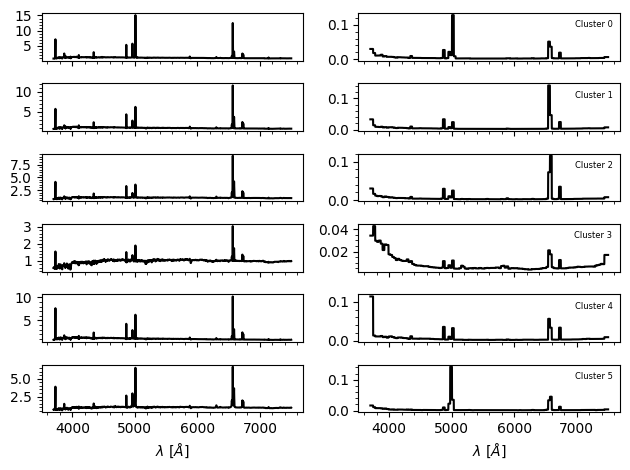

In [10]:
fig, axs = plt.subplots(
    nrows=6,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_weights = cluster_weights.mean(axis=0)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    # axs[label, 1].set_ylim(0., 1.)


axs[5,0].set_xlabel("$\lambda$ [$\AA$]")
axs[5,1].set_xlabel("$\lambda$ [$\AA$]")

## Cluster all explanation weights

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_324895/2228499620.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters-1,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_324895/2228499620.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters-1,1].set_xlabel("$\lambda$ [$\AA$]")


(10000, 3773)
train time: 1.99 seconds
Cluster: 0,N. spectra: 1309
Cluster: 1,N. spectra: 2729
Cluster: 2,N. spectra: 2002
Cluster: 3,N. spectra: 1454
Cluster: 4,N. spectra: 1408
Cluster: 5,N. spectra: 1098


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_noRel100)')

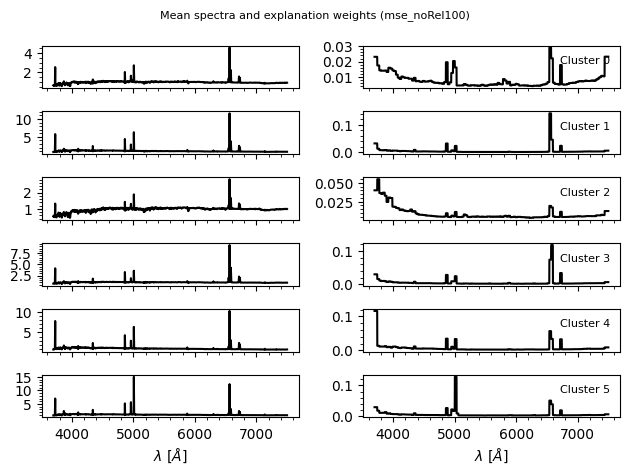

In [14]:
X = mse_dict["norm_abs_weights"]
print(X.shape)
n_clusters = 6

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_dict["anomalies_array"],
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=n_clusters,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    # axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[n_clusters-1,0].set_xlabel("$\lambda$ [$\AA$]")
axs[n_clusters-1,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({mse_dict['metric']})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

### Plot centroids

#### Average spectra of cluster 0

#### Average spectra of cluster 1

#### Average spectra of cluster 2

#### Average spectra of cluster 3

#### Average spectra of cluster 4


#### closest spectra to centroids

# mse_filter_250kms_noRel97

In [16]:
mse_filter_97_dict = {
    "metric": "mse_filter_250kms_noRel97",
    "run_id": "20250427105355_uniform_5000_scale",
    "weights": None,
    "unique_weights": None,
}

mse_filter_97_dict["weights"] = np.load(
    f"{explanations_dir}/{bin_id}/"
    f"{mse_filter_97_dict['metric']}/"
    f"weights_{mse_filter_97_dict['run_id']}.npy"
)

mse_filter_97_dict["unique_weights"] = clustering.get_weights_per_segments(
    weights=mse_filter_97_dict["weights"],
    n_segments=128
)

mse_filter_97_dict["anomalies_array"] = np.load(
    f"{spectra_dir}/{bin_id}/{mse_filter_97_dict['metric']}/top_anomalies.npy",
    mmap_mode="r"
)

mse_filter_97_dict["anomalies_df"] = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{mse_filter_97_dict['metric']}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(mse_filter_97_dict["weights"])
norm_abs_weights = normalize(
    norm_abs_weights, norm='l2', axis=1
)
mse_filter_97_dict["norm_abs_weights"] = norm_abs_weights

Base size: 29, Residual size: 61
New number of segments: 129


## Cluster unique explanation weights

In [17]:
X = mse_filter_97_dict["unique_weights"]
X = np.abs(X)
X = normalize(X, norm='l2', axis=1)

norm_abs_weights = np.abs(mse_filter_97_dict["weights"])
norm_abs_weights = normalize(
    norm_abs_weights, norm='l2', axis=1
)

n_clusters = 6

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_filter_97_dict["anomalies_array"],
    weights=norm_abs_weights,
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_filter_97_dict["anomalies_array"],
    weights=X,
    print_n_clusters=False
)

centroids = kmeans.cluster_centers_


train time: 0.08 seconds
Cluster: 0,N. spectra: 1765
Cluster: 1,N. spectra: 782
Cluster: 2,N. spectra: 2925
Cluster: 3,N. spectra: 2395
Cluster: 4,N. spectra: 901
Cluster: 5,N. spectra: 1232


<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_324895/2369569866.py:42: SyntaxWarning: invalid escape sequence '\l'
  axs[5,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_324895/2369569866.py:43: SyntaxWarning: invalid escape sequence '\l'
  axs[5,1].set_xlabel("$\lambda$ [$\AA$]")


Text(0.5, 0, '$\\lambda$ [$\\AA$]')

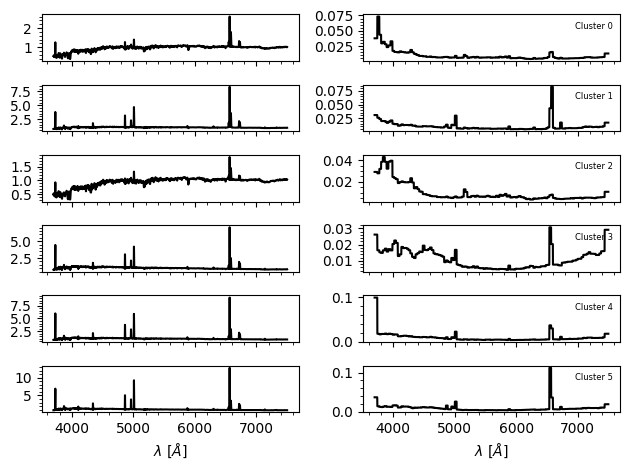

In [18]:
fig, axs = plt.subplots(
    nrows=6,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_weights = cluster_weights.mean(axis=0)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    # axs[label, 1].set_ylim(0., 1.)


axs[5,0].set_xlabel("$\lambda$ [$\AA$]")
axs[5,1].set_xlabel("$\lambda$ [$\AA$]")

# MSE filter 250 kms noRel100

In [26]:
score_name = "mse_filter_250kms_noRel100"
explanation_run_id = "20250427094150_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.93 seconds
Cluster: 0,N. spectra: 2677
Cluster: 1,N. spectra: 3254
Cluster: 2,N. spectra: 2153
Cluster: 3,N. spectra: 699
Cluster: 4,N. spectra: 1217


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_filter_250kms_noRel100)')

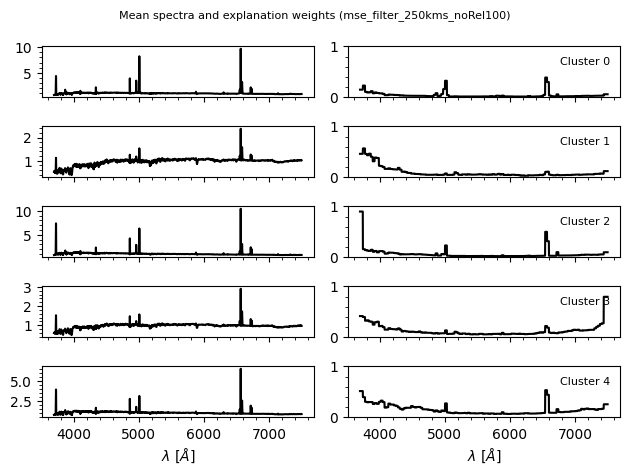

In [27]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

# MSE filter 250 kms noRel97

In [ ]:
score_name = "mse_filter_250kms_noRel97"
explanation_run_id = "20250427105355_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.94 seconds
Cluster: 0,N. spectra: 2677
Cluster: 1,N. spectra: 3254
Cluster: 2,N. spectra: 2153
Cluster: 3,N. spectra: 699
Cluster: 4,N. spectra: 1217


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_filter_250kms_noRel100)')

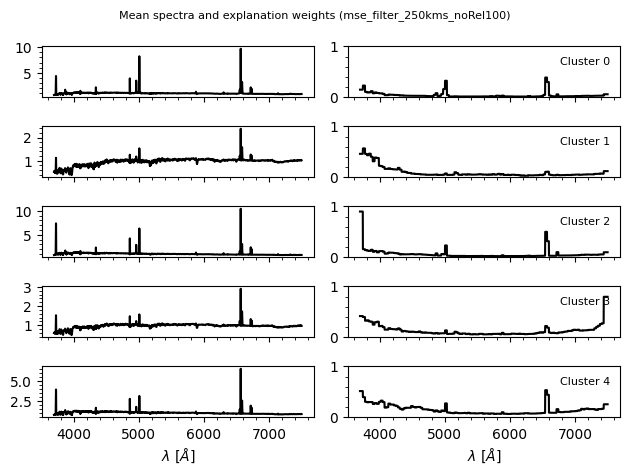

In [28]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)